- Subconjuntos.m: EEG 세그먼트 로드
- Unir.m: 부분적으로 가져온 EEG 세그먼트 및 subset 결합
- FiltroMediana.m: 중앙값 필터로 얻은 값으로 NaN 교체 (노이즈 및 누락 값 대체)
- Car.m: CAR(common average reference) method를 통한 신호 참조 (노이즈 및 누락 값 대체), EEG 신호에서 평균 뺌
- FiltroPasaBanda.m: 8-30hz 대역 통과(bandpass) 필터 (α(8–13Hz) 및 β(13–30Hz) 대역)
- OrganizarDatos.m: [n 샘플, n 채널] 구조
- Etiquetas.m: train/test session 분할, label 0부터 시작

In [ ]:
# activate google drive
from google.colab import drive
# mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 모듈 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.signal import spectrogram
import pywt
import cv2
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout,
                          TimeDistributed, LSTM)
from keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint
from keras import backend as K

K.image_data_format()   # 'channels_last' 출력 시 작동

'channels_last'

In [ ]:
# train & test data BCI-IV-2b
x_train = pd.read_csv("/content/drive/My Drive/MI-EEG-B2T.csv",
                      header=None)
x_test = pd.read_csv("/content/drive/My Drive/MI-EEG-B2E.csv",
                     header=None)
y_train = pd.read_csv("/content/drive/My Drive/etiquetas_train2.csv",
                      header=None)
y_test = pd.read_csv("/content/drive/My Drive/etiquetas_test2.csv",
                     header=None)

# x_train, x_test: 행=인스턴스 수, 열=채널 수 샘플링 주파수에 의한 시간(초)
# y_train, y_test: 레이블
print(x_train.shape)    # (400, 3000)
print(x_test.shape)     # (320, 3000)
print(y_train.shape)    # (400, 1)
print(y_test.shape)     # (320, 1)

(400, 3000)
(280, 3000)
(400, 1)
(280, 1)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# sample 수 계산
print("n_samples_train:", len(y_train))  # 400
print("n_samples_test :", len(y_test))   # 320, x_test 대체 가능
# class 수 계산
n_classes = len(np.unique(y_test))
print("n_classes:", n_classes)  # 2

n_samples_train: 400
n_samples_test : 280
n_classes: 2


In [ ]:
# CWT로 스케일로그램 계산, n-채널 스케일로그램의 수직 결합
# unir_escalogramas_vertical(x_train 또는 x_test의 matrix, 샘플 주파수,
# 높이, 너비, n_channels, 신호 세그먼트 크기):
def unir_escalogramas_vertical(data, fs, height, width, n_channels, pts_sig):  # 250, 135, 1000, 3, 1000
  # Open CV를 사용하여 크기 조정
  dim = (int(np.floor(width/2)), int(np.floor(height/2))) # 너비, 높이
  
  # Morlet complex wavelet 3-3 스케일 계산
  # 0.5Hz 간격의 8~30Hz의 주파수
  escalas = pywt.scale2frequency('cmor3-3', np.arange(8,30.5,0.5)) / (1/fs)
  
  datos = np.zeros((data.shape[0], int(np.floor(height/2)),
                    int(np.floor(width/2))))    # 모든 이미지 저장을 위한 3D matrix 생성
  temporal = np.zeros((height, width))            # # 각 이미지 저장을 위한 2D matrix 생성

  for i in range(data.shape[0]): # n 샘플
    for j in range(n_channels): # n 채널
      # puntos_sig = 신호 지속 시간(초) x 샘플링 주파수 (fs=250Hz인 2초 신호의 puntos_sig = 500)
      sig = data.iloc[i, j*pts_sig:(j+1)*pts_sig]
      
      # CWT를 사용한 스케일로그램
      # pywt.cwt(신호, 스케일, 웨이블릿 이름=Morlet complex 3-3, 샘플 기간=1/샘플 주파수)
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3',
                             sampling_period = (1 / fs))
      
      # 채널의 수직 연결
      # spectrogram은 45개의 행(0.5Hz 간격의 8~30Hz의 주파수)과 31개의 열(시간) 생성
      # cmor3-3은 복소수 생성
      temporal[j*45:(j+1)*45, :] = abs(coef)

    # OpenCV로 영역 간 보간 사용하여 크기 조정
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: # 진행과정 확인
      print(i)
  return datos

In [ ]:
inicio = time.time()

# CWT
x_train = unir_escalogramas_vertical(x_train, 250, 135, 1000, 3, 1000)
x_test = unir_escalogramas_vertical(x_test, 250, 135, 1000, 3, 1000)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
200
300
0
100
200
Tiempo: 41.1584358215332


In [ ]:
# spectrograms(STFT) / scallograms(CWT)의 3차원 shape
# 예시의 수, 이미지의 높이, 이미지의 너비
print(x_train.shape)    # (400, 135, 31)
print(x_test.shape)     # (320, 135, 31)

(400, 67, 500)
(280, 67, 500)


In [ ]:
print(x_train[1].shape)

(67, 500)


In [ ]:
print(x_train[1])

[[0.41195529 0.41364128 0.42990759 ... 0.67263644 0.66228406 0.66785644]
 [0.27171925 0.27010463 0.27649908 ... 0.60607093 0.58400998 0.57117759]
 [0.21985143 0.1997402  0.23219515 ... 0.90080737 0.90934199 0.87787677]
 ...
 [0.18063629 0.16965581 0.16544381 ... 0.59989232 0.58745955 0.56144877]
 [0.26177128 0.26709527 0.26235894 ... 0.51201856 0.4929087  0.48151664]
 [0.31715164 0.32807837 0.32635115 ... 0.4798575  0.46766118 0.44784071]]


In [ ]:
# x_train과 x_test의 최대, 최소, 평균의 합 출력
print(np.max(x_train))  # 10.7888912416627
print(np.max(x_test))   # 5.9735068449728965
print(np.min(x_train))  # 3.407406192918792e-08
print(np.min(x_test))   # 4.7948568293571226e-08
print(np.mean(x_train)) # 0.07563276860670194
print(np.mean(x_test))  # 0.054174781359652736

5.427213683138092
7.672842956993291
0.00613370458238611
0.008411448732244085
0.6264100656607616
0.5885881225287259


In [ ]:
x = np.ceil(np.max(x_train))    # x_train의 최대값 반올림
x_train = x_train.astype('float32') # float로 type 변환
x_test = x_test.astype('float32')

x_train /= x    # 0~1 범위의 스케일 값(정규화)
x_test /= x

In [ ]:
# 정규화 후의 x_train과 x_test의 최대, 최소, 평균의 합 출력
print(np.max(x_train))  # 0.98080826
print(np.max(x_test))   # 0.54304606
print(np.min(x_train))  # 3.0976421e-09
print(np.min(x_test))   # 4.3589607e-09
print(np.mean(x_train)) # 0.0068757054
print(np.mean(x_test))  # 0.004924981

0.9045356
1.2788072
0.001022284
0.0014019081
0.10440171
0.098098025


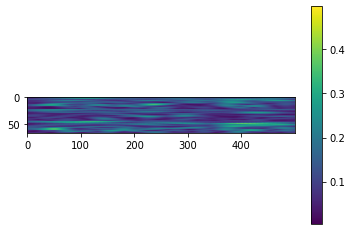

In [ ]:
# x_train 예시 2 plotting
plt.figure()
plt.imshow(x_train[1])
plt.colorbar()
plt.show()

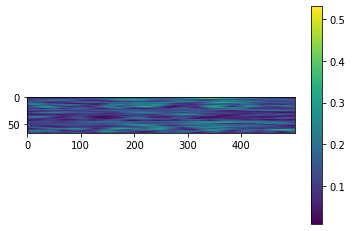

In [ ]:
# x_train 예시 2 plotting
plt.figure()
plt.imshow(x_train[5])
plt.colorbar()
plt.show()

In [ ]:
# 3D -> 4D 변환(CNN-2D)
#x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
#x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

# 3D -> 5D 변환 (CNN-2D + LSTM)
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(400, 1, 67, 500, 1)
(280, 1, 67, 500, 1)


In [ ]:
# descomentar para guardar el modelo
#mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2b/Modelos/STFT_CNN_09.hdf5',
#                     monitor='val_accuracy', save_best_only=True, verbose=0)

In [ ]:
# CNN-2D + LSTM 신경망 생성
# 필터의 수, 필터의 크기,
# MLP(Dense)의 은닉층에 있는 뉴런의 수와
# LSTM 단위
# relu 활성화 및
# 제로 패딩 및 2x2 최대 풀링
# 특징 맵을 평면화하여 3D 매트릭스에서 다음으로 변환합니다.
# 1D 벡터
# 하이퍼볼릭 탄젠트 활성화 및 드롭아웃이 0.5인 LSTM 순환 신경망
# (컨볼루션 레이어와 MLP 사이에 위치)
# relu를 사용한 은닉층의 MLP
# 드롭아웃이 0.5인 정규화
# 마지막 레이어는 softmax 함수를 사용하여 분포를 얻습니다.
# 확률 
# 학습률이 1x10-4인 Adam 옵티마이저
# 손실 함수는 범주 교차 엔트로피입니다.
# (태그를 하나의 핫 태그로 변환하지 않으려면 sparse를 사용하십시오.)
# 평가할 메트릭은 정확도입니다.
# CNN-2D와 LSTM을 연결하려면 TimeDistributed 레이어를 사용해야 합니다.
def CNN_2D_LSTM_TD(n_filtros, tamano_filtros, n_neuronas, unidades_LSTM):
  model = Sequential()
  model.add(TimeDistributed(Conv2D(n_filtros, tamano_filtros, activation='relu',
                                   padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(n_filtros, tamano_filtros, activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(unidades_LSTM, activation='tanh', dropout=0.5))
  model.add(Dense(n_neuronas, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


loss:  0.8462820649147034
accuracy:  0.5142857432365417
9/9 [==============================] - 0s 5ms/step
kappa:  0.02857142857142858
confusion matrix:
 [[58 82]
 [54 86]]


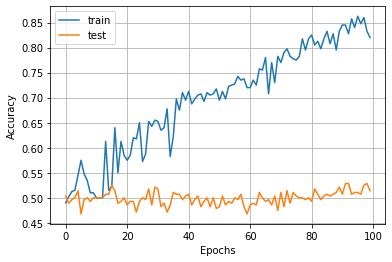

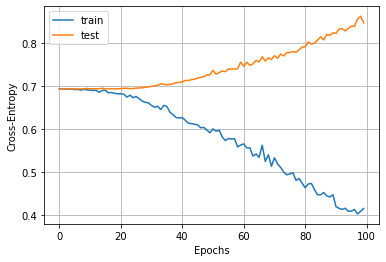

Iteration: 2


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


loss:  0.8658818006515503
accuracy:  0.5249999761581421
9/9 [==============================] - 0s 5ms/step
kappa:  0.050000000000000044
confusion matrix:
 [[87 53]
 [80 60]]


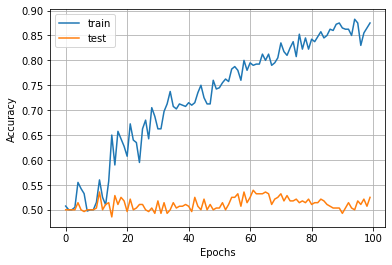

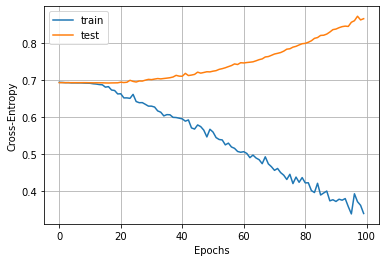

Iteration: 3


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


loss:  1.0615789890289307
accuracy:  0.46071428060531616
9/9 [==============================] - 0s 5ms/step
kappa:  -0.07857142857142851
confusion matrix:
 [[70 70]
 [81 59]]


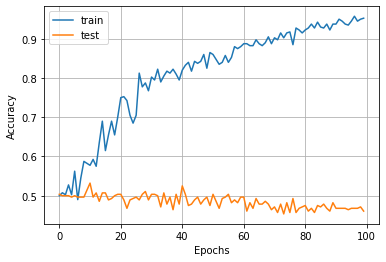

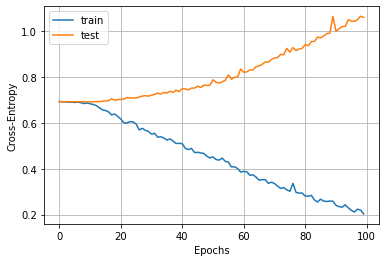

Iteration: 4


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


loss:  0.8617818355560303
accuracy:  0.5249999761581421
9/9 [==============================] - 0s 5ms/step
kappa:  0.050000000000000044
confusion matrix:
 [[85 55]
 [78 62]]


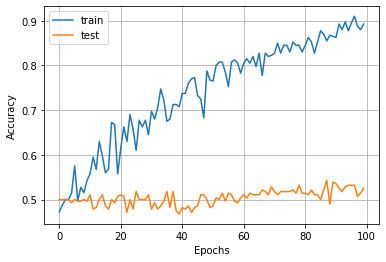

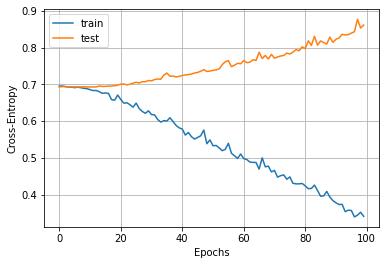

Iteration: 5


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


loss:  0.8966923952102661
accuracy:  0.5107142925262451
9/9 [==============================] - 0s 6ms/step
kappa:  0.021428571428571463
confusion matrix:
 [[73 67]
 [70 70]]


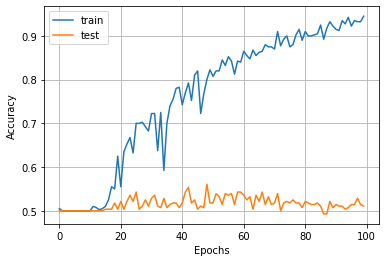

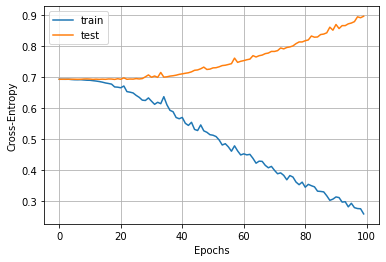


Resultados:
loss: [0.8462820649147034, 0.8658818006515503, 1.0615789890289307, 0.8617818355560303, 0.8966923952102661]
accuracy: [0.5142857432365417, 0.5249999761581421, 0.46071428060531616, 0.5249999761581421, 0.5107142925262451]
kappa: [0.02857142857142858, 0.050000000000000044, -0.07857142857142851, 0.050000000000000044, 0.021428571428571463]
Tiempo: 134.55549097061157


In [ ]:
inicio = time.time()
array_loss = [] # 손실에 대한 배열
array_acc = [] # 정확성을 위한 배열
array_kappa = [] # 카파 배열
for i in range(5): # numero de ejecuciones
  print("Iteration:", i+1)

  # seleccionar la red neuronal
  model = CNN_2D_LSTM_TD(8, (3,3), 16, 8)

  # 신경망 훈련
    # STFT의 경우 = 400 에포크, CWT의 경우 = 100 에포크
    # batch_size: 크기는 선택 사항입니다(데이터 세트에 따라 다름).
    # x_train: 배열
    # y_train: 레이블
    # epochs: 에포크 수
    # batch_size: 배치 크기(훈련이 작을수록 더 오래 걸립니다)
    # validation_data: 이 데이터는 각 에포크에서 네트워크를 평가하기 위한 것입니다.
      # 이 데이터는 교육에 사용되지 않는다는 점을 언급하는 것이 중요합니다.
      # 네트워크는 각 에포크에서만 평가됩니다.
    # verbose: 0은 훈련 과정을 인쇄하지 않고 다른 옵션은
      # 1 또는 2가 될 수 있습니다.
  # callbacks: guardar el modelo en cada epoca y reemplazar solo si es mejor
    #al anterior
  history = model.fit(x_train, y_train, epochs=100, batch_size=36,
                      validation_data=(x_test, y_test), verbose=0)
                      #,callbacks=[mc]) # descomentar para guardar el modelo
    
  # x_test 및 y_test로 신경망 평가
  # (트레이닝에서 네트워크에 제시된 적이 없는 데이터)
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

  array_loss.append(test_loss) # array_loss 배열에 test_loss를 추가합니다.
  print("loss: ", test_loss)
  array_acc.append(test_acc) # array_acc 배열에 test_acc 추가
  print("accuracy: ", test_acc)
  
  # predecir x_test (확률 분포)
  probabilidades = model.predict(x_test)
  
  # 최대 인덱스를 계산하여 예측 레이블을 얻습니다.
  # 확률 분포
  y_pred = np.argmax(probabilidades, 1) # 1 = fila
    
  # 코헨의 카파 계산
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa) # array_acc 배열에 test_acc 추가
  print("kappa: ", kappa)
  
  # 혼동 행렬 계산
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  # graficar el comportamiento del accuracy y de la perdida en cada epoca
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
fin = time.time()
tiempo = fin - inicio
print("Tiempo:", tiempo)

In [ ]:
# 모델 요약(신경망)
# 각 레이어의 출력 형태를 보여주고
# 각 레이어에서 학습할 매개변수의 수
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 1, 67, 500, 8)    80        
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 1, 33, 250, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 1, 33, 250, 8)    584       
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 1, 16, 125, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 1, 16000)        

In [ ]:
# 인쇄 평균, 표준 편차 및 최대 정확도 및 카파
# 전체 교차 유효성 검사 프로세스의 실행 시간
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("Tiempo:", int(tiempo))

Mean Accuracy: 0.5071
std: (+/- 0.0239)
Mean Kappa: 0.0143
std: (+/- 0.0478)
Max Accuracy: 0.5250
Max Kappa: 0.0500
Tiempo: 134


In [ ]:
# informacion de la GPU
# solo utilizar si esta utilizando usa GPU de Google Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Dec 23 02:27:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    39W /  70W |   2022MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------